---
#Copy of L177 - Examine Feature Maps

(code below is from `DUDL_CNN_GaussClassFeatureMaps.ipynb`)


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,TensorDataset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Helper to determine shapes of feature maps / final vectorisation connection to FCN...

In [2]:
def calculate_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output size after applying a filter.
    """
    output_size = int((input_size - kernel_size + 2 * padding) / stride) + 1
    return output_size

# Example usage:
input_size = 128  # Example input image size (e.g., 224x224 pixels)
kernel_size = 3   # Kernel size
stride = 3        # Stride
padding = 0       # Padding

# Calculate the output size after Conv2d
conv_output_size = calculate_output_size(input_size, kernel_size, stride, padding)

# Calculate the output size after MaxPool2d (assuming a 2x2 pool with stride 2)
pool_output_size = calculate_output_size(conv_output_size, 2, 2, 0)

print(f"Output size after Conv2d: {conv_output_size}x{conv_output_size}")
print(f"Output size after MaxPool2d: {pool_output_size}x{pool_output_size}")

# Calculate the number of nodes for the fully connected layer
# Assuming the output is a square and there are 'n_filters' number of filters
n_filters = 64  # Number of filters in the Conv2d layer
fc_nodes = pool_output_size * pool_output_size * n_filters
print(f"Number of nodes for the fully connected layer: {fc_nodes}")

Output size after Conv2d: 42x42
Output size after MaxPool2d: 21x21
Number of nodes for the fully connected layer: 28224


In [3]:
# Use a local directory of images with ImageFolder instead of CIFAR-10

from torchvision.datasets import ImageFolder

# Set your image directory path here
image_dir = 'D:/2024_My_AI_art/512x512_5step_FigureStudy'  # Change as needed

# Define the transformations for the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Ensure all images are the same size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(root=image_dir, transform=transform)

# Split into train/test sets (80/20 split)
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(trainset, batch_size=512, shuffle=True)
testloader = DataLoader(testset, batch_size=512, shuffle=False)

# Check the size of an image
print('image shape: ', trainset[0][0].shape)

# Dataset sizes
print('len(trainset): ', len(trainset))
print('len(testset) : ', len(testset))

image shape:  torch.Size([3, 128, 128])
len(trainset):  88
len(testset) :  22


In [7]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3,10,5,padding=2, stride=2) # input chs, output chs, kernel, padding=2, stride=2
      
      self.conv2 = nn.Conv2d(10,16,5,padding=2, stride=2) # input chs, output chs, kernel, padding=2, stride=2
      
      # Calculate the correct input size for the first FC layer
      # For input 128x128:
      # After conv1 (stride=2, padding=2, kernel=5): output = (128-5+2*2)//2 + 1 = 64
      # After maxpool2d (2,2): output = 64//2 = 32
      # After conv2 (stride=2, padding=2, kernel=5): output = (32-5+2*2)//2 + 1 = 16
      # After maxpool2d (2,2): output = 16//2 = 8
      # Final feature map: 16 channels, 8x8 each -> 16*8*8 = 1024

      self.fc1 = nn.Linear(1024,150) # match to flattened output of conv layers

      self.fc2 = nn.Linear(150,10)

    def forward(self,x):
      # first conv-pool block
      FM1 = F.leaky_relu(self.conv1(x))  # grab the activation of the first conv layer (post-leaky relu)
      x = F.max_pool2d(FM1,(2,2))

      # second conv-pool block
      FM2 = F.leaky_relu(self.conv2(x)) # grab the activation of the second conv layer (post-leaky relu)
      x = F.max_pool2d(FM2,(2,2))

      # FCN part
      x = x.reshape(x.shape[0],-1) # flatten the input
      # Print shape for debugging if needed
      # print("Flattened shape before FC:", x.shape)
      x = F.relu( self.fc1(x) ) # pass through the first FC layer
      x = self.fc2(x) # pass through the second FC layer(output layer)
      return x,FM1,FM2 #returns results AND Feature Maps

  # create the model instance
  net = gausnet()

  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(),lr=.002)

  return net,lossfun,optimizer

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()
net.to(device) # move the model to the GPU

# test that the model runs and can compute a loss
X,y = next(iter(trainloader))
X = X.to(device) # move X to the GPU
y = y.to(device) # move y to the GPU

#print the type of X and y
#print(type(X),type(y))

#X = X.float()  # Convert X to float
yHat,featmap1,featmap2 = net(X) # get the feature maps as well as yHat predictions
loss = lossfun(yHat,y)

# check sizes of outputs
print('Predicted category:')
print(yHat.shape)
print('\nFeature map after conv1')
print(featmap1.shape)
print('\nFeature map after conv2')
print(featmap2.shape)

Predicted category:
torch.Size([88, 10])

Feature map after conv1
torch.Size([88, 10, 64, 64])

Feature map after conv2
torch.Size([88, 16, 16, 16])


In [10]:
# count the total number of parameters in the model - pass a single input image through the model       
summary(net)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            760
├─Conv2d: 1-2                            4,016
├─Linear: 1-3                            153,750
├─Linear: 1-4                            1,510
Total params: 160,036
Trainable params: 160,036
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            760
├─Conv2d: 1-2                            4,016
├─Linear: 1-3                            153,750
├─Linear: 1-4                            1,510
Total params: 160,036
Trainable params: 160,036
Non-trainable params: 0

kernel.shape:  torch.Size([10, 3, 5, 5])

k1: max= 0.11432661   min= -0.1043137 
 [[-0.01225881  0.06128307 -0.10033016  0.05742222  0.07173143]
 [ 0.11432661 -0.07800198 -0.1043137  -0.0021342   0.06588508]
 [ 0.10577592  0.07679723 -0.05649131  0.10060889 -0.06238624]
 [-0.03820701  0.11339821 -0.07580692 -0.02584514  0.0804285 ]
 [ 0.07235758 -0.02266068  0.06193532 -0.08516102 -0.06789315]]

k2: max= 0.10631211   min= -0.09966568 
 [[-0.0548382   0.07693909  0.07908788  0.03429893  0.06644978]
 [ 0.0015748   0.02795663 -0.06810609  0.01138654  0.10578421]
 [-0.01021664  0.03571148 -0.09966568 -0.04350995  0.00066436]
 [-0.0966033   0.09703971 -0.0313866  -0.01599337  0.04293056]
 [-0.09643258 -0.07636287  0.10631211  0.04430163  0.05592836]]


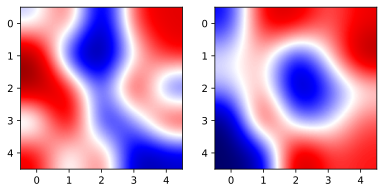

In [11]:
# view first convolution layer kernels. note these will be random noise since the model has not been trained
# re-run this cell after training to see the learned kernels

layer = list(net.modules())[1] # get the first layer (conv1)
kernel = layer.weight.data.cpu() # get the kernel weights, move to cpu
print('kernel.shape: ',kernel.shape)
k1=kernel[0,0,:,:].numpy() # get the first kernel, convert to numpy
k2=kernel[1,0,:,:].numpy() # get the second kernel, convert to numpy
rangemax = max(k1.max(),k2.max())
rangemin = min(k1.min(),k2.min())

print('\nk1: max=',k1.max(),'  min=',k1.min(),'\n',k1)
print('\nk2: max=',k2.max(),'  min=',k2.min(),'\n',k2)

# plot the 2 kernels
fig,ax = plt.subplots(1,2)
ax[0].imshow(kernel[0,0,:,:],cmap='seismic',vmin=rangemin,vmax=rangemax,interpolation='bicubic')
ax[1].imshow(kernel[1,0,:,:],cmap='seismic',vmin=rangemin,vmax=rangemax,interpolation='bicubic')


In [12]:
def function2trainTheModel():
  numepochs = 4

  # create a new model
  net,lossfun,optimizer = makeTheNet()
  net.to(device) # move the model to the GPU

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)

  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in trainloader:
      X = X.to(device) # move X to the GPU
      y = y.to(device) # move y to the GPU

      # forward pass and loss
      X = X.float()           # convert to float
      yHat = net(X)[0]        # only need the first output
      loss = lossfun(yHat,y)

      optimizer.zero_grad()   # backprop
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( (torch.argmax(yHat, dim=1) == y).float().mean().item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # calc TEST accuracy
    X,y = next(iter(testloader))  # extract X,y from test dataloader
    X = X.to(device)              # move to GPU
    y = y.to(device)              # move to GPU
    with torch.no_grad():         # deactivate autograd
      X = X.float()               # convert to float
      yHat = net(X)[0]            # only need the first output, no labels
      loss = lossfun(yHat,y)

    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean((torch.argmax(yHat, dim=1) == y).float()).item()
    print ('epoch: ',epochi, ' test Accuracy: ',testAcc[epochi].item())
    print ('percent complete: ',100*(epochi+1)/numepochs,'%')
  return trainLoss,testLoss,trainAcc,testAcc,net

TRAIN model, show results

In [13]:
trainLoss, testLoss, trainAcc, testAcc, net = function2trainTheModel()


epoch:  0  test Accuracy:  100.0
percent complete:  25.0 %
epoch:  1  test Accuracy:  100.0
percent complete:  50.0 %
epoch:  1  test Accuracy:  100.0
percent complete:  50.0 %
epoch:  2  test Accuracy:  100.0
percent complete:  75.0 %
epoch:  2  test Accuracy:  100.0
percent complete:  75.0 %
epoch:  3  test Accuracy:  100.0
percent complete:  100.0 %
epoch:  3  test Accuracy:  100.0
percent complete:  100.0 %


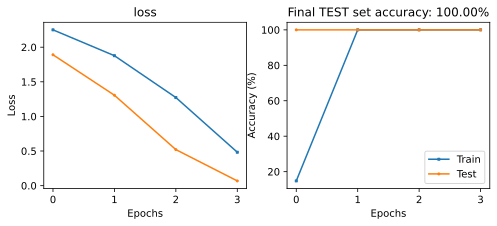

In [14]:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(trainLoss,'s-',label='Train',markersize=2)
ax[0].plot(testLoss,'o-',label='Test',markersize=2)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('loss')

ax[1].plot(trainAcc,'s-',label='Train',markersize=2)
ax[1].plot(testAcc,'o-',label='Test',markersize=2)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final TEST set accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [15]:
device = next(net.parameters()).device
print(device)

cuda:0


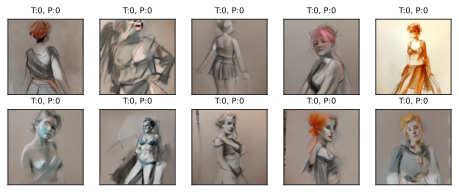

In [17]:
# visualize some images
X, y = next(iter(testloader)) # extract X, y from test dataloader
X = X.to(device) # move to GPU
y = y.to(device) # move to GPU
yHat,featmap1,featmap2 = net(X.float())

fig,axs = plt.subplots(2,5,figsize=(8,3))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,:,:,:] ).detach().cpu()
  ax.imshow(G.permute(1,2,0)/2+.5)
  t = ( int(y[i].item()) , torch.argmax(yHat[i]).item() )
  #set small font size
  ax.set_title('T:%s, P:%s'%t,fontsize=8)
  
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

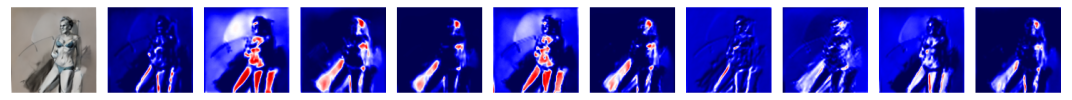

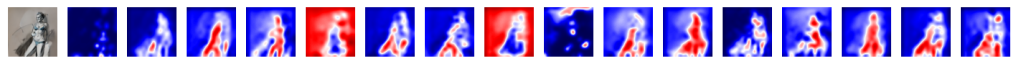

In [19]:
#plot feature maps from the conv1 layer

datapoint=6 # choose a data point (keep it below (batchsize))
FM1count=10 # number of feature maps in the first conv layer
# Display the original image
plt.figure(figsize=(15,2))  # Adjust the figure size to comfortably fit the plots
plt.subplot(1, FM1count+1, 1)  # 1 row, 7 columns, 1st subplot

img = X[datapoint,:,:,:].detach().permute(1,2,0)  # Get the image and permute the dimensions
img_unnorm = img*0.5 + 0.5                        # Unnormalize the image
img_unnorm = img_unnorm.cpu().numpy()             # Convert the image to a numpy array
plt.imshow(img_unnorm)                            # Display the image
plt.axis('off')                                   # Hide axis

# Display the feature maps
for i in range(FM1count):
    a = featmap1[datapoint,i,:,:].detach().cpu()        # batch x channel x height x width
    plt.subplot(1, FM1count+1, i+2)                              # 1 row, 7 columns, (i+2)th subplot
    plt.imshow(a, cmap='seismic',interpolation='bicubic')  # Display the feature map
    plt.axis('off')                                     # Hide axis

plt.tight_layout()  # Adjust the layout so the plots don't overlap
plt.show()

#================================================================================================
# do the same for the second layer
FM2count=16 # number of feature maps in the second conv layer
plt.figure(figsize=(18,3))      # Adjust the figure size to comfortably fit the plots
plt.subplot(1, FM2count+1, 1)           # 1 row, 9 columns, 1st subplot

img = X[datapoint,:,:,:].detach().permute(1,2,0).cpu()  # Get the image and permute the dimensions
img_unnorm = img*0.5 + 0.5                        # Unnormalize the image
plt.imshow(img_unnorm)                            # Display the image
plt.axis('off')                                   # Hide axis ticks and labels

# Display the feature maps
for i in range(FM2count):
    a = featmap2[datapoint,i,:,:].detach().cpu()              # batch x channel x height x width
    plt.subplot(1, FM2count+1, i+2)                              # 1 row, 9 columns, (i+2)th subplot
    plt.imshow(a, cmap='seismic',interpolation='bicubic')  # Display the feature map
    plt.axis('off')                                     # Hide axis ticks and labels